In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import explained_variance_score, r2_score
from sklearn.model_selection import cross_validate
import tensorflow as tf
from sklearn.metrics import mean_squared_error as MSE
from pathlib import Path
from sklearn.metrics import classification_report
import xgboost as xg 
from xgboost import XGBClassifier
import pandas as pd , numpy as np , datetime, os
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras import layers
import seaborn as sns,  matplotlib.pyplot as plt, joblib as jlib
import tensorflow as tf, keras_tuner, tensorflow.keras as keras
from tensorflow.keras import layers



In [2]:
pip install csv-to-sqlite

Note: you may need to restart the kernel to use updated packages.


In [3]:
import csv_to_sqlite

In [4]:
options = csv_to_sqlite.CsvOptions(typing_style="full", encoding="UTF-8")
#change path to "Resources/insurance.csv" for jupyter notebook
input_files = ['Resources/insurance.csv']
#change path to "Resources/insurance.sqlite" for jupyter notebook
csv_to_sqlite.write_csv(input_files, "Resources/insurance.sqlite", options)


Error on table Resources/insurance.csv: 
 table [insurance] already exists
Written 0 rows into 1 tables in 0.013 seconds


0

In [5]:
import sqlalchemy
from sqlalchemy import create_engine, text, inspect, func
import warnings
engine = create_engine("sqlite:///Resources/insurance.sqlite")

#gives warning but easier to get the dataframe from querying
warnings.filterwarnings('ignore')
conn = engine.raw_connection()
insurance_df = pd.read_sql_query(sql=f"SELECT age ,sex, bmi, children, smoker , region , ROUND(charges,2) as charges FROM insurance", con=conn)

In [6]:
insurance_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92
1,18,male,33.770,1,no,southeast,1725.55
2,28,male,33.000,3,no,southeast,4449.46
3,33,male,22.705,0,no,northwest,21984.47
4,32,male,28.880,0,no,northwest,3866.86
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.55
1334,18,female,31.920,0,no,northeast,2205.98
1335,18,female,36.850,0,no,southeast,1629.83
1336,21,female,25.800,0,no,southwest,2007.95


In [7]:
insurance_df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [8]:
# @title OneHot + MinMax
df1 = insurance_df.copy()

col_to_encode = ['sex', 'smoker', 'region']

X_OneHot_model = OneHotEncoder(sparse_output=False)
X_OH_fit = X_OneHot_model.fit(insurance_df[col_to_encode])


df_encoded =  pd.DataFrame(X_OneHot_model.transform(insurance_df[col_to_encode]), columns=X_OneHot_model.get_feature_names_out())
df1 = df1.drop(col_to_encode, axis=1).merge(df_encoded, left_index=True, right_index=True)
df1.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,18,33.770,1,1725.55,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,28,33.000,3,4449.46,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,33,22.705,0,21984.47,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,32,28.880,0,3866.86,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [9]:
X_min_max_scaler = MinMaxScaler()
X_fit_scaler = X_min_max_scaler.fit(df1[['age','bmi','children']])
df1[['age','bmi','children']] = X_fit_scaler.transform(df1[['age','bmi','children']])


In [10]:
X = df1.drop('charges', axis = 1)
X.head(5)

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,0.021739,0.321227,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.000000,0.479150,0.2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.217391,0.458434,0.6,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.326087,0.181464,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.304348,0.347592,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [11]:
y_min_max_scaler = MinMaxScaler()
y_fit_scaler = y_min_max_scaler.fit(df1[['charges']])
y = y_fit_scaler.transform(df1[['charges']])
y.ravel().reshape(1,-1)

array([[0.25161073, 0.00963598, 0.05311519, ..., 0.00810809, 0.01414366,
        0.44724875]])

In [12]:
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state = 123)
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(1003, 11) (335, 11) (1003, 1) (335, 1)


# Chart / Plot

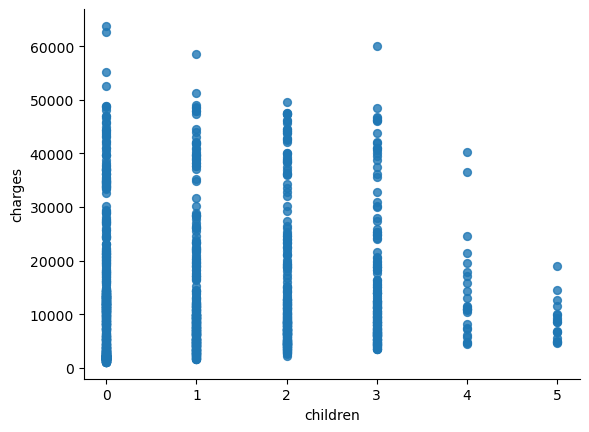

In [13]:
insurance_df.plot(kind='scatter', x='children', y='charges', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [14]:
train_X.columns

Index(['age', 'bmi', 'children', 'sex_female', 'sex_male', 'smoker_no',
       'smoker_yes', 'region_northeast', 'region_northwest',
       'region_southeast', 'region_southwest'],
      dtype='object')

In [15]:
train_y

array([[0.27911879],
       [0.00815933],
       [0.33855048],
       ...,
       [0.0193085 ],
       [0.00930317],
       [0.7269053 ]])

# XGboost

In [16]:
# # Instantiation 
# #xgb_r  = GridSearchCV(
#             estimator=xg.XGBRegressor(),
#             param_grid={"learning_rate": (0.05, 0.10, 0.15),
#                         "max_depth": [ 3, 4, 5, 6, 8, None],
#                         "min_child_weight": [ 1, 3, 5, 7],
#                         "gamma":[ 0.0, 0.1, 0.2],
#                         "colsample_bytree":[ 0.3, 0.4, 0.8]},
#              scoring='neg_mean_absolute_error', verbose=3, n_jobs=-1)

In [17]:
# Instantiation 
xgb_r  = GridSearchCV(
            estimator=xg.XGBRegressor(),
            param_grid={"learning_rate": (0.05, 0.10, 0.15),
                        "n_estimators" : (100, 200, 300, 500),
                        "max_depth": [ 3, 4, 5, 6, 8, None],
                        "min_child_weight": [ 1, 3, 5, 7],
                        "gamma":[ 0.0, 0.1, 0.2],
                        "colsample_bytree":[ 0.3, 0.4, 0.8]},
             scoring='neg_mean_absolute_error', verbose=3, n_jobs=-1)

grid_result = MultiOutputRegressor(xgb_r).fit(train_X, train_y)
best_params = grid_result.best_params_

Fitting 5 folds for each of 2592 candidates, totalling 12960 fits
[CV 2/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200;, score=-0.043 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=100;, score=-0.051 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=100;, score=-0.055 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=200;, score=-0.042 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300;, score=-0.047 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=100;, score=-0.051 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3,

[CV 4/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100;, score=-0.055 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=100;, score=-0.058 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=100;, score=-0.059 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=200;, score=-0.050 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300;, score=-0.045 total time=   0.1s
[CV 1/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=200;, score=-0.050 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=5, n

[CV 3/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100;, score=-0.059 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=500;, score=-0.048 total time=   0.1s
[CV 4/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=200;, score=-0.046 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500;, score=-0.048 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=100;, score=-0.058 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=200;, score=-0.046 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=5, n

[CV 1/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=100;, score=-0.057 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=100;, score=-0.049 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=100;, score=-0.055 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=100;, score=-0.051 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=None, min_child_weight=5, n_estimators=100;, score=-0.057 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=None, min_child_weight=5, n_estimators=100;, score=-0.048 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=None, min_child_weight=5,

[CV 1/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=None, min_child_weight=7, n_estimators=100;, score=-0.055 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=None, min_child_weight=7, n_estimators=100;, score=-0.048 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=None, min_child_weight=7, n_estimators=100;, score=-0.054 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=None, min_child_weight=7, n_estimators=100;, score=-0.049 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=5, n_estimators=500;, score=-0.045 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=5, n_estimators=500;, score=-0.053 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_wei

[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=200;, score=-0.051 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=200;, score=-0.059 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=200;, score=-0.055 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=200;, score=-0.059 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=300;, score=-0.057 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=300;, score=-0.051 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=3, n

[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=300;, score=-0.059 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=300;, score=-0.055 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=300;, score=-0.059 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=500;, score=-0.057 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300;, score=-0.059 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300;, score=-0.055 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=3, n

[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=500;, score=-0.055 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=500;, score=-0.059 total time=   0.1s
[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=None, min_child_weight=5, n_estimators=200;, score=-0.055 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=None, min_child_weight=5, n_estimators=200;, score=-0.058 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=None, min_child_weight=5, n_estimators=300;, score=-0.057 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=None, min_child_weight=5, n_estimators=300;, score=-0.051 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=None, min_ch

[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300;, score=-0.059 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=500;, score=-0.055 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300;, score=-0.059 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300;, score=-0.055 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300;, score=-0.059 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500;, score=-0.055 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estima

[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1, n_estimators=100;, score=-0.056 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1, n_estimators=100;, score=-0.057 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1, n_estimators=200;, score=-0.055 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1, n_estimators=200;, score=-0.051 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1, n_estimators=200;, score=-0.058 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=5, n_estimators=100;, score=-0.055 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=5, n

[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=3, min_child_weight=7, n_estimators=300;, score=-0.056 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=3, min_child_weight=7, n_estimators=300;, score=-0.051 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=100;, score=-0.055 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=100;, score=-0.051 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=100;, score=-0.058 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=100;, score=-0.056 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=5, n

[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=3, n_estimators=300;, score=-0.058 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=3, n_estimators=300;, score=-0.056 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=3, n_estimators=300;, score=-0.057 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=3, n_estimators=500;, score=-0.055 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=3, n_estimators=500;, score=-0.051 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=3, n_estimators=500;, score=-0.058 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=3, n

[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=200;, score=-0.051 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=200;, score=-0.058 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=200;, score=-0.056 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=200;, score=-0.057 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=300;, score=-0.055 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=300;, score=-0.051 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=7, n

[CV 3/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=200;, score=-0.064 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=100;, score=-0.063 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=100;, score=-0.056 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=100;, score=-0.065 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=100;, score=-0.060 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=100;, score=-0.064 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=8, min_child_weight=5, n

[CV 2/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500;, score=-0.055 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500;, score=-0.064 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500;, score=-0.061 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500;, score=-0.063 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=500;, score=-0.055 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=500;, score=-0.064 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estima

[CV 4/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=200;, score=-0.061 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=200;, score=-0.063 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300;, score=-0.061 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300;, score=-0.055 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=200;, score=-0.061 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=200;, score=-0.063 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estima

[CV 3/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=200;, score=-0.064 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=200;, score=-0.061 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=200;, score=-0.063 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=300;, score=-0.061 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=300;, score=-0.055 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500;, score=-0.055 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estima

[CV 2/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300;, score=-0.055 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300;, score=-0.064 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300;, score=-0.061 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300;, score=-0.063 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500;, score=-0.061 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=5, n_estimators=100;, score=-0.061 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=5, n_estima

[CV 4/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=100;, score=-0.061 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=100;, score=-0.062 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=200;, score=-0.062 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=200;, score=-0.054 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=200;, score=-0.065 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=4, min_child_weight=7, n_estimators=300;, score=-0.065 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=4, min_child_weight=7, n

[CV 1/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=7, n_estimators=300;, score=-0.062 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=7, n_estimators=300;, score=-0.054 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=6, min_child_weight=5, n_estimators=200;, score=-0.061 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=6, min_child_weight=5, n_estimators=200;, score=-0.062 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=6, min_child_weight=5, n_estimators=300;, score=-0.062 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=6, min_child_weight=5, n_estimators=300;, score=-0.054 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=6, min_child_weight=5, n

[CV 5/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=100;, score=-0.050 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=200;, score=-0.047 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=200;, score=-0.040 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=200;, score=-0.048 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=200;, score=-0.043 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=200;, score=-0.045 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, n

[CV 1/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=100;, score=-0.052 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=100;, score=-0.044 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=100;, score=-0.052 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=100;, score=-0.047 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100;, score=-0.050 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=200;, score=-0.049 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=3, n

[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100;, score=-0.046 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100;, score=-0.053 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100;, score=-0.048 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=200;, score=-0.046 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=200;, score=-0.048 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=300;, score=-0.053 total time=   0.1s
[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=1, n

[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=300;, score=-0.047 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=500;, score=-0.053 total time=   0.1s
[CV 3/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=500;, score=-0.058 total time=   0.1s
[CV 4/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=500;, score=-0.051 total time=   0.1s
[CV 5/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=500;, score=-0.050 total time=   0.1s
[CV 1/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=100;, score=-0.058 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=3, n

[CV 5/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500;, score=-0.047 total time=   0.1s
[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=500;, score=-0.047 total time=   0.1s
[CV 3/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=500;, score=-0.053 total time=   0.1s
[CV 4/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=500;, score=-0.047 total time=   0.1s
[CV 5/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=500;, score=-0.048 total time=   0.1s
[CV 1/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=100;, score=-0.056 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=7, n

[CV 4/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=100;, score=-0.043 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=200;, score=-0.045 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=200;, score=-0.045 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300;, score=-0.052 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300;, score=-0.045 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300;, score=-0.053 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estima

[CV 5/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300;, score=-0.044 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500;, score=-0.051 total time=   0.1s
[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500;, score=-0.044 total time=   0.1s
[CV 3/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500;, score=-0.052 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500;, score=-0.044 total time=   0.1s
[CV 5/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500;, score=-0.045 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estima

[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=None, min_child_weight=5, n_estimators=500;, score=-0.054 total time=   0.1s
[CV 3/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=None, min_child_weight=5, n_estimators=500;, score=-0.061 total time=   0.1s
[CV 4/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=None, min_child_weight=5, n_estimators=500;, score=-0.052 total time=   0.1s
[CV 5/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=None, min_child_weight=5, n_estimators=500;, score=-0.055 total time=   0.1s
[CV 1/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=None, min_child_weight=7, n_estimators=100;, score=-0.052 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=None, min_child_weight=7, n_estimators=100;, score=-0.048 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=None, min_chi

[CV 5/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=5, n_estimators=200;, score=-0.045 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=5, n_estimators=300;, score=-0.050 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=5, n_estimators=300;, score=-0.043 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=5, n_estimators=300;, score=-0.052 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=5, n_estimators=300;, score=-0.045 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=5, n_estimators=300;, score=-0.046 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=5, n

[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=5, n_estimators=500;, score=-0.053 total time=   0.1s
[CV 3/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=5, n_estimators=500;, score=-0.063 total time=   0.1s
[CV 4/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=5, n_estimators=500;, score=-0.053 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=5, n_estimators=500;, score=-0.055 total time=   0.1s
[CV 1/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=7, n_estimators=100;, score=-0.052 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=7, n_estimators=100;, score=-0.045 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=7, n

[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1, n_estimators=300;, score=-0.053 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1, n_estimators=300;, score=-0.059 total time=   0.1s
[CV 4/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1, n_estimators=300;, score=-0.050 total time=   0.1s
[CV 5/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1, n_estimators=300;, score=-0.053 total time=   0.1s
[CV 1/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1, n_estimators=500;, score=-0.060 total time=   0.1s
[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=500;, score=-0.059 total time=   0.1s
[CV 3/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=1, n

[CV 5/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300;, score=-0.055 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500;, score=-0.054 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=200;, score=-0.052 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=200;, score=-0.055 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=300;, score=-0.054 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=300;, score=-0.048 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n

[CV 4/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=300;, score=-0.052 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=300;, score=-0.055 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=500;, score=-0.054 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300;, score=-0.056 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300;, score=-0.052 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300;, score=-0.055 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=3, n

[CV 1/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=500;, score=-0.055 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=200;, score=-0.051 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=200;, score=-0.055 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=300;, score=-0.055 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=300;, score=-0.047 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=300;, score=-0.056 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estima

[CV 5/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=None, min_child_weight=3, n_estimators=500;, score=-0.055 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100;, score=-0.055 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100;, score=-0.048 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100;, score=-0.056 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100;, score=-0.051 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100;, score=-0.054 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=5, n_es

[CV 4/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=100;, score=-0.051 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300;, score=-0.056 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300;, score=-0.051 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300;, score=-0.055 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500;, score=-0.055 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500;, score=-0.048 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estima

[CV 1/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=500;, score=-0.054 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=3, n_estimators=100;, score=-0.054 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=3, n_estimators=200;, score=-0.054 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=3, n_estimators=200;, score=-0.047 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=3, n_estimators=200;, score=-0.056 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=3, n_estimators=200;, score=-0.052 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=3, n

[CV 4/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=7, n_estimators=300;, score=-0.052 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=7, n_estimators=300;, score=-0.054 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=7, n_estimators=500;, score=-0.054 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=7, n_estimators=500;, score=-0.047 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=7, n_estimators=500;, score=-0.056 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=7, n_estimators=500;, score=-0.052 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=7, n

[CV 4/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=7, n_estimators=200;, score=-0.052 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=7, n_estimators=200;, score=-0.054 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=7, n_estimators=300;, score=-0.054 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=7, n_estimators=300;, score=-0.047 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=5, n_estimators=500;, score=-0.047 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=5, n_estimators=500;, score=-0.056 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=5, n

[CV 3/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=200;, score=-0.060 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=200;, score=-0.055 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=200;, score=-0.058 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=300;, score=-0.058 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=300;, score=-0.051 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=200;, score=-0.055 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=6, min_child_weight=5, n

[CV 4/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=None, min_child_weight=5, n_estimators=200;, score=-0.055 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=None, min_child_weight=5, n_estimators=200;, score=-0.058 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=None, min_child_weight=5, n_estimators=300;, score=-0.058 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=None, min_child_weight=5, n_estimators=300;, score=-0.051 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=None, min_child_weight=5, n_estimators=300;, score=-0.060 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=None, min_child_weight=5, n_estimators=300;, score=-0.055 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=None, 

[CV 1/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=None, min_child_weight=3, n_estimators=500;, score=-0.058 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=None, min_child_weight=3, n_estimators=500;, score=-0.051 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=None, min_child_weight=3, n_estimators=500;, score=-0.060 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=None, min_child_weight=3, n_estimators=500;, score=-0.055 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=None, min_child_weight=3, n_estimators=500;, score=-0.058 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=200;, score=-0.055 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=3, min_chil

[CV 4/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=200;, score=-0.055 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=200;, score=-0.059 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300;, score=-0.059 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300;, score=-0.052 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=200;, score=-0.055 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=200;, score=-0.059 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estima

[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300;, score=-0.052 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=500;, score=-0.052 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=500;, score=-0.060 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=500;, score=-0.055 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=500;, score=-0.059 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100;, score=-0.059 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estima

[CV 1/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=100;, score=-0.059 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=100;, score=-0.052 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=100;, score=-0.060 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=100;, score=-0.055 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=100;, score=-0.059 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=200;, score=-0.059 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estima

[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3, n_estimators=200;, score=-0.054 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3, n_estimators=200;, score=-0.062 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3, n_estimators=200;, score=-0.057 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3, n_estimators=200;, score=-0.062 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3, n_estimators=300;, score=-0.062 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3, n_estimators=300;, score=-0.054 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=6, min_child_weight=1, n

[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=6, min_child_weight=3, n_estimators=500;, score=-0.054 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=6, min_child_weight=3, n_estimators=500;, score=-0.062 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=6, min_child_weight=3, n_estimators=500;, score=-0.057 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=6, min_child_weight=3, n_estimators=500;, score=-0.062 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=8, min_child_weight=5, n_estimators=100;, score=-0.062 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=8, min_child_weight=5, n_estimators=100;, score=-0.054 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=8, min_child_weight=5, n

[CV 2/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100;, score=-0.040 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100;, score=-0.046 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100;, score=-0.041 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100;, score=-0.042 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200;, score=-0.045 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200;, score=-0.040 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, n

[CV 4/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=None, min_child_weight=3, n_estimators=100;, score=-0.057 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=None, min_child_weight=7, n_estimators=300;, score=-0.062 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=None, min_child_weight=7, n_estimators=300;, score=-0.057 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=None, min_child_weight=7, n_estimators=300;, score=-0.062 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=None, min_child_weight=7, n_estimators=500;, score=-0.062 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=None, min_child_weight=7, n_estimators=500;, score=-0.054 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=None, 

[CV 1/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=100;, score=-0.045 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=100;, score=-0.040 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=100;, score=-0.046 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=100;, score=-0.042 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=100;, score=-0.042 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=200;, score=-0.045 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=5, n

[CV 4/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=200;, score=-0.043 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=200;, score=-0.041 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300;, score=-0.047 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300;, score=-0.041 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=200;, score=-0.042 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=200;, score=-0.043 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1, n

[CV 1/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500;, score=-0.055 total time=   0.1s
[CV 2/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500;, score=-0.051 total time=   0.1s
[CV 3/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500;, score=-0.059 total time=   0.1s
[CV 4/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500;, score=-0.048 total time=   0.1s
[CV 5/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500;, score=-0.049 total time=   0.1s
[CV 5/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=100;, score=-0.044 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estima

[CV 1/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=200;, score=-0.053 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=200;, score=-0.049 total time=   0.1s
[CV 3/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=200;, score=-0.055 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=100;, score=-0.052 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=100;, score=-0.047 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=100;, score=-0.055 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estima

[CV 3/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=300;, score=-0.059 total time=   0.1s
[CV 4/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=300;, score=-0.050 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=300;, score=-0.049 total time=   0.1s
[CV 1/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=500;, score=-0.057 total time=   0.1s
[CV 2/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=500;, score=-0.055 total time=   0.1s
[CV 3/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=500;, score=-0.062 total time=   0.1s
[CV 4/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estima

[CV 1/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500;, score=-0.060 total time=   0.1s
[CV 2/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500;, score=-0.055 total time=   0.1s
[CV 3/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500;, score=-0.063 total time=   0.1s
[CV 4/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500;, score=-0.055 total time=   0.1s
[CV 5/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500;, score=-0.053 total time=   0.1s
[CV 4/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=5, n_estimators=200;, score=-0.050 total time=   0.1s
[CV 5/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=5, n_estima

[CV 4/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=5, n_estimators=200;, score=-0.043 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=5, n_estimators=200;, score=-0.044 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=5, n_estimators=300;, score=-0.051 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=5, n_estimators=300;, score=-0.047 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=5, n_estimators=300;, score=-0.054 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=5, n_estimators=300;, score=-0.044 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=5, n

[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=100;, score=-0.052 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=100;, score=-0.047 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=100;, score=-0.050 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=200;, score=-0.052 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=200;, score=-0.045 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=200;, score=-0.052 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n

[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=500;, score=-0.046 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=500;, score=-0.051 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300;, score=-0.045 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=100;, score=-0.050 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=200;, score=-0.052 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=200;, score=-0.045 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=7, n_e

[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100;, score=-0.052 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100;, score=-0.046 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100;, score=-0.052 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100;, score=-0.047 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=500;, score=-0.046 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=500;, score=-0.052 total time=   0.1s
[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=1, n

[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=200;, score=-0.047 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=200;, score=-0.050 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=300;, score=-0.052 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=300;, score=-0.046 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=300;, score=-0.052 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=300;, score=-0.047 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=1, n

[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=100;, score=-0.051 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=100;, score=-0.046 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=100;, score=-0.051 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=100;, score=-0.047 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=100;, score=-0.050 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=200;, score=-0.051 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estima

[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=500;, score=-0.046 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=500;, score=-0.052 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=500;, score=-0.047 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=500;, score=-0.050 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200;, score=-0.047 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200;, score=-0.050 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_es

[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=500;, score=-0.046 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=500;, score=-0.050 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=200;, score=-0.047 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=200;, score=-0.050 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=300;, score=-0.052 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=300;, score=-0.046 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estima

[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=None, min_child_weight=5, n_estimators=500;, score=-0.046 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=None, min_child_weight=5, n_estimators=500;, score=-0.051 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=None, min_child_weight=5, n_estimators=500;, score=-0.047 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=None, min_child_weight=5, n_estimators=500;, score=-0.050 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=None, min_child_weight=7, n_estimators=100;, score=-0.051 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=None, min_child_weight=7, n_estimators=100;, score=-0.046 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=None, min_chi

[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=100;, score=-0.051 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=100;, score=-0.045 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=100;, score=-0.051 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=100;, score=-0.047 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=100;, score=-0.051 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=200;, score=-0.051 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=5, n

[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=5, n_estimators=500;, score=-0.051 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=300;, score=-0.051 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=300;, score=-0.047 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=300;, score=-0.051 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=500;, score=-0.051 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=500;, score=-0.045 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=3, n

[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=1, n_estimators=500;, score=-0.045 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=1, n_estimators=500;, score=-0.051 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=1, n_estimators=500;, score=-0.047 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=1, n_estimators=500;, score=-0.051 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=100;, score=-0.051 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=100;, score=-0.045 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=3, n

AttributeError: 'MultiOutputRegressor' object has no attribute 'best_params_'

In [18]:
xgb_r.fit(train_X, train_y)

Fitting 5 folds for each of 2592 candidates, totalling 12960 fits
[CV 3/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=100;, score=-0.056 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=100;, score=-0.051 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=100;, score=-0.055 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=200;, score=-0.056 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=200;, score=-0.049 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=200;, score=-0.056 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8,

[CV 5/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=7, n_estimators=100;, score=-0.055 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=7, n_estimators=200;, score=-0.056 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=7, n_estimators=200;, score=-0.048 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=None, min_child_weight=3, n_estimators=200;, score=-0.056 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=None, min_child_weight=3, n_estimators=200;, score=-0.049 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=None, min_child_weight=3, n_estimators=200;, score=-0.056 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=None, min_child

[CV 1/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=None, min_child_weight=7, n_estimators=100;, score=-0.056 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=None, min_child_weight=7, n_estimators=100;, score=-0.049 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=None, min_child_weight=7, n_estimators=100;, score=-0.056 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=None, min_child_weight=7, n_estimators=100;, score=-0.051 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100;, score=-0.055 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200;, score=-0.056 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_we

[CV 3/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=200;, score=-0.057 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=200;, score=-0.051 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=200;, score=-0.055 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300;, score=-0.056 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300;, score=-0.048 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100;, score=-0.056 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estima

[CV 2/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=500;, score=-0.048 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=500;, score=-0.057 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=500;, score=-0.051 total time=   0.1s
[CV 5/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=500;, score=-0.055 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100;, score=-0.056 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100;, score=-0.048 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estima

[CV 4/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=200;, score=-0.051 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=200;, score=-0.055 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300;, score=-0.056 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300;, score=-0.048 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=5, n_estimators=500;, score=-0.048 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=5, n_estimators=500;, score=-0.057 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=5, n_estima

[CV 3/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=7, n_estimators=200;, score=-0.055 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=7, n_estimators=200;, score=-0.051 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=7, n_estimators=200;, score=-0.055 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=7, n_estimators=300;, score=-0.056 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=7, n_estimators=300;, score=-0.048 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=100;, score=-0.056 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.15, max_depth=4, min_child_weight=5, n

[CV 4/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=3, n_estimators=500;, score=-0.051 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=3, n_estimators=500;, score=-0.055 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=500;, score=-0.048 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=500;, score=-0.055 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=500;, score=-0.051 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=500;, score=-0.055 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.15, max_depth=4, min_child_weight=7, n

[CV 4/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.15, max_depth=6, min_child_weight=5, n_estimators=200;, score=-0.051 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.15, max_depth=6, min_child_weight=5, n_estimators=200;, score=-0.055 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.15, max_depth=6, min_child_weight=5, n_estimators=300;, score=-0.056 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.15, max_depth=6, min_child_weight=5, n_estimators=300;, score=-0.048 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.15, max_depth=6, min_child_weight=5, n_estimators=300;, score=-0.055 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.15, max_depth=6, min_child_weight=5, n_estimators=300;, score=-0.051 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.15, max_depth=6, min_child_weight=5, n

[CV 3/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=200;, score=-0.050 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500;, score=-0.041 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500;, score=-0.049 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=200;, score=-0.046 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=200;, score=-0.049 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300;, score=-0.048 total time=   0.1s
[CV 2/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=7, n

[CV 2/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300;, score=-0.042 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100;, score=-0.059 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=200;, score=-0.052 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=200;, score=-0.045 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=200;, score=-0.050 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100;, score=-0.059 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=3, n

[CV 2/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=100;, score=-0.055 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=100;, score=-0.061 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=100;, score=-0.057 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=300;, score=-0.059 total time=   0.1s
[CV 4/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=300;, score=-0.052 total time=   0.1s
[CV 5/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=300;, score=-0.053 total time=   0.1s
[CV 1/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=3, n

[CV 3/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=200;, score=-0.057 total time=   0.1s
[CV 3/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=300;, score=-0.055 total time=   0.1s
[CV 4/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=300;, score=-0.050 total time=   0.1s
[CV 5/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=300;, score=-0.050 total time=   0.1s
[CV 1/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=500;, score=-0.059 total time=   0.1s
[CV 2/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=500;, score=-0.052 total time=   0.1s
[CV 3/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=7, n

[CV 5/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=500;, score=-0.050 total time=   0.1s
[CV 2/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500;, score=-0.052 total time=   0.1s
[CV 3/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500;, score=-0.061 total time=   0.1s
[CV 4/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500;, score=-0.053 total time=   0.1s
[CV 5/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500;, score=-0.052 total time=   0.1s
[CV 1/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=100;, score=-0.055 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estima

[CV 1/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500;, score=-0.055 total time=   0.1s
[CV 2/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500;, score=-0.047 total time=   0.1s
[CV 3/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500;, score=-0.053 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500;, score=-0.048 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500;, score=-0.046 total time=   0.1s
[CV 5/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=100;, score=-0.049 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estima

[CV 1/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=200;, score=-0.058 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=200;, score=-0.050 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=200;, score=-0.056 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=200;, score=-0.050 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=200;, score=-0.050 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=300;, score=-0.060 total time=   0.1s
[CV 2/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=7, n_estima

[CV 2/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=1, n_estimators=300;, score=-0.043 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=1, n_estimators=300;, score=-0.050 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=1, n_estimators=300;, score=-0.045 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=1, n_estimators=300;, score=-0.046 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=1, n_estimators=500;, score=-0.052 total time=   0.1s
[CV 1/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=5, n_estimators=100;, score=-0.048 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=5, n

[CV 5/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=1, n_estimators=500;, score=-0.060 total time=   0.1s
[CV 1/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=100;, score=-0.060 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=100;, score=-0.052 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=100;, score=-0.058 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=100;, score=-0.053 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=None, min_child_weight=1, n_estimators=500;, score=-0.059 total time=   0.1s
[CV 3/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=None, min_child_weigh

[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500;, score=-0.058 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=100;, score=-0.059 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=100;, score=-0.052 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=100;, score=-0.060 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=100;, score=-0.056 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=100;, score=-0.059 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=5, n

[CV 3/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=None, min_child_weight=3, n_estimators=300;, score=-0.061 total time=   0.1s
[CV 4/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=None, min_child_weight=3, n_estimators=300;, score=-0.053 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=None, min_child_weight=3, n_estimators=300;, score=-0.053 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=None, min_child_weight=3, n_estimators=500;, score=-0.064 total time=   0.1s
[CV 2/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=None, min_child_weight=3, n_estimators=500;, score=-0.057 total time=   0.1s
[CV 3/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=None, min_child_weight=3, n_estimators=500;, score=-0.065 total time=   0.1s
[CV 4/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=None, 

[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300;, score=-0.051 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=200;, score=-0.055 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=200;, score=-0.058 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=300;, score=-0.057 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=300;, score=-0.051 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=300;, score=-0.059 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n

[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=200;, score=-0.051 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=200;, score=-0.059 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=200;, score=-0.055 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=200;, score=-0.059 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=300;, score=-0.057 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=300;, score=-0.051 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=1, n

[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200;, score=-0.059 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100;, score=-0.055 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100;, score=-0.051 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100;, score=-0.059 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100;, score=-0.055 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100;, score=-0.059 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estima

[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=500;, score=-0.055 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=500;, score=-0.051 total time=   0.1s
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=500;, score=-0.059 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=500;, score=-0.055 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=500;, score=-0.059 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=100;, score=-0.055 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estima

[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300;, score=-0.051 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300;, score=-0.059 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300;, score=-0.055 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300;, score=-0.059 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500;, score=-0.055 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500;, score=-0.051 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estima

[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=None, min_child_weight=3, n_estimators=100;, score=-0.055 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=None, min_child_weight=3, n_estimators=100;, score=-0.051 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=None, min_child_weight=3, n_estimators=100;, score=-0.059 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=None, min_child_weight=3, n_estimators=100;, score=-0.055 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=3, min_child_weight=1, n_estimators=100;, score=-0.055 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=3, min_child_weight=1, n_estimators=100;, score=-0.051 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=3, min_child_wei

[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=3, n_estimators=300;, score=-0.057 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=3, n_estimators=500;, score=-0.055 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=3, n_estimators=500;, score=-0.051 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=3, n_estimators=500;, score=-0.058 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=3, n_estimators=500;, score=-0.056 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=3, n_estimators=500;, score=-0.057 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=5, n

[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=3, min_child_weight=7, n_estimators=500;, score=-0.056 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=3, min_child_weight=7, n_estimators=500;, score=-0.051 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=3, min_child_weight=7, n_estimators=500;, score=-0.058 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=3, min_child_weight=7, n_estimators=500;, score=-0.056 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=3, min_child_weight=7, n_estimators=500;, score=-0.057 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=7, n_estimators=100;, score=-0.057 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=7, n

[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=500;, score=-0.055 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=500;, score=-0.051 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=500;, score=-0.058 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=500;, score=-0.056 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=500;, score=-0.057 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=None, min_child_weight=5, n_estimators=200;, score=-0.056 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=None, min_child_weigh

[CV 2/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=300;, score=-0.055 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=300;, score=-0.064 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=300;, score=-0.059 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=300;, score=-0.063 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=500;, score=-0.062 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300;, score=-0.064 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=6, min_child_weight=3, n

[CV 5/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500;, score=-0.063 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=100;, score=-0.063 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=100;, score=-0.056 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=100;, score=-0.065 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=100;, score=-0.060 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=100;, score=-0.063 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=5, n

[CV 3/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=None, min_child_weight=7, n_estimators=100;, score=-0.065 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=None, min_child_weight=7, n_estimators=100;, score=-0.060 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100;, score=-0.061 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100;, score=-0.055 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100;, score=-0.064 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100;, score=-0.061 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=5, 

[CV 5/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=None, min_child_weight=3, n_estimators=500;, score=-0.063 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500;, score=-0.055 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500;, score=-0.064 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500;, score=-0.061 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500;, score=-0.063 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=100;, score=-0.061 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=7, n_es

[CV 3/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=200;, score=-0.064 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=5, n_estimators=500;, score=-0.055 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=5, n_estimators=500;, score=-0.064 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=5, n_estimators=500;, score=-0.061 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=5, n_estimators=500;, score=-0.063 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=100;, score=-0.061 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=7, n_estima

[CV 4/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=300;, score=-0.061 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=300;, score=-0.063 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=500;, score=-0.061 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=100;, score=-0.063 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=200;, score=-0.061 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=200;, score=-0.055 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=7, n_estima

[CV 1/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=1, n_estimators=500;, score=-0.062 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=7, n_estimators=100;, score=-0.062 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=7, n_estimators=200;, score=-0.062 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=7, n_estimators=200;, score=-0.054 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=7, n_estimators=200;, score=-0.065 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=7, n_estimators=200;, score=-0.061 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=7, n

[CV 3/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=200;, score=-0.065 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=100;, score=-0.062 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=100;, score=-0.054 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=100;, score=-0.065 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=100;, score=-0.061 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=100;, score=-0.062 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=4, min_child_weight=5, n

[CV 5/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=100;, score=-0.062 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=200;, score=-0.062 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=200;, score=-0.054 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=200;, score=-0.065 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=6, min_child_weight=5, n_estimators=100;, score=-0.062 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=6, min_child_weight=5, n_estimators=100;, score=-0.054 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=6, min_child_weight=5, n

[CV 3/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=8, min_child_weight=7, n_estimators=200;, score=-0.065 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=8, min_child_weight=7, n_estimators=200;, score=-0.061 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=8, min_child_weight=7, n_estimators=200;, score=-0.062 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=8, min_child_weight=7, n_estimators=300;, score=-0.062 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=8, min_child_weight=7, n_estimators=300;, score=-0.054 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=None, min_child_weight=5, n_estimators=200;, score=-0.061 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=None, min_child_weigh

[CV 4/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300;, score=-0.042 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300;, score=-0.045 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500;, score=-0.047 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500;, score=-0.042 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500;, score=-0.049 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500;, score=-0.043 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=7, n

[CV 1/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=500;, score=-0.054 total time=   0.1s
[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=500;, score=-0.047 total time=   0.1s
[CV 3/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=500;, score=-0.053 total time=   0.1s
[CV 4/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=500;, score=-0.047 total time=   0.1s
[CV 5/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=500;, score=-0.048 total time=   0.1s
[CV 3/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300;, score=-0.052 total time=   0.1s
[CV 4/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=7, n

[CV 3/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300;, score=-0.049 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300;, score=-0.043 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300;, score=-0.044 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500;, score=-0.051 total time=   0.1s
[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500;, score=-0.044 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500;, score=-0.052 total time=   0.1s
[CV 4/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estima

[CV 1/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=500;, score=-0.061 total time=   0.2s
[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=500;, score=-0.057 total time=   0.1s
[CV 3/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=500;, score=-0.062 total time=   0.1s
[CV 4/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=500;, score=-0.053 total time=   0.1s
[CV 5/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=500;, score=-0.053 total time=   0.1s
[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=None, min_child_weight=5, n_estimators=500;, score=-0.050 total time=   0.1s
[CV 3/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=None, min_child_weigh

[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=None, min_child_weight=7, n_estimators=100;, score=-0.048 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=None, min_child_weight=7, n_estimators=100;, score=-0.053 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=None, min_child_weight=7, n_estimators=100;, score=-0.046 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=5, n_estimators=100;, score=-0.048 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=5, n_estimators=100;, score=-0.041 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=5, n_estimators=100;, score=-0.048 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weigh

[CV 1/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=200;, score=-0.054 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=200;, score=-0.048 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=200;, score=-0.056 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100;, score=-0.054 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100;, score=-0.048 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100;, score=-0.056 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n

[CV 5/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=3, n_estimators=200;, score=-0.050 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=3, n_estimators=300;, score=-0.059 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=3, n_estimators=300;, score=-0.052 total time=   0.1s
[CV 4/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=200;, score=-0.050 total time=   0.1s
[CV 5/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=200;, score=-0.052 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=300;, score=-0.061 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=1, n

[CV 1/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=200;, score=-0.055 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=200;, score=-0.049 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=200;, score=-0.056 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=200;, score=-0.052 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=200;, score=-0.055 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=300;, score=-0.055 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=3, n

[CV 5/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=None, min_child_weight=3, n_estimators=300;, score=-0.055 total time=   0.1s
[CV 1/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=None, min_child_weight=3, n_estimators=500;, score=-0.065 total time=   0.1s
[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=None, min_child_weight=3, n_estimators=500;, score=-0.061 total time=   0.1s
[CV 3/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=None, min_child_weight=3, n_estimators=500;, score=-0.066 total time=   0.1s
[CV 4/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=None, min_child_weight=3, n_estimators=500;, score=-0.056 total time=   0.1s
[CV 5/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=None, min_child_weight=3, n_estimators=500;, score=-0.058 total time=   0.1s
[CV 2/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=3, min

[CV 3/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=200;, score=-0.056 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=200;, score=-0.052 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=200;, score=-0.055 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=300;, score=-0.055 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=300;, score=-0.048 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=None, min_child_weight=5, n_estimators=200;, score=-0.052 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=None, min_child_weigh

[CV 5/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=200;, score=-0.055 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=300;, score=-0.055 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=300;, score=-0.048 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=300;, score=-0.056 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=300;, score=-0.052 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=300;, score=-0.055 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=5, n

[CV 5/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=500;, score=-0.055 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=100;, score=-0.055 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=100;, score=-0.048 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=100;, score=-0.056 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=100;, score=-0.051 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=100;, score=-0.055 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estima

[CV 4/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=100;, score=-0.051 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=100;, score=-0.055 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=200;, score=-0.055 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=200;, score=-0.048 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=200;, score=-0.056 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=200;, score=-0.051 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estima

[CV 4/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=7, n_estimators=100;, score=-0.052 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=300;, score=-0.056 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=300;, score=-0.052 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=300;, score=-0.054 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=500;, score=-0.054 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=500;, score=-0.047 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=3, n

[CV 4/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=5, n_estimators=300;, score=-0.052 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=5, n_estimators=300;, score=-0.054 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=5, n_estimators=500;, score=-0.054 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=None, min_child_weight=3, n_estimators=100;, score=-0.054 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=None, min_child_weight=3, n_estimators=200;, score=-0.054 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=None, min_child_weight=3, n_estimators=200;, score=-0.047 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=None, min_child

[CV 1/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100;, score=-0.058 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100;, score=-0.051 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100;, score=-0.060 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100;, score=-0.055 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=100;, score=-0.058 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=200;, score=-0.058 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=7, n

[CV 1/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=100;, score=-0.058 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=100;, score=-0.051 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=100;, score=-0.060 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=100;, score=-0.055 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=100;, score=-0.058 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=200;, score=-0.058 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=5, min_child_weight=3, n

[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=200;, score=-0.051 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=200;, score=-0.060 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=200;, score=-0.055 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=200;, score=-0.058 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=300;, score=-0.058 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=300;, score=-0.051 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=8, min_child_weight=7, n

[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300;, score=-0.052 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300;, score=-0.060 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300;, score=-0.055 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300;, score=-0.059 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500;, score=-0.059 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=100;, score=-0.059 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estima

[CV 3/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300;, score=-0.060 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300;, score=-0.055 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300;, score=-0.059 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500;, score=-0.059 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500;, score=-0.052 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500;, score=-0.060 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estima

[CV 4/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=300;, score=-0.055 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=300;, score=-0.059 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=500;, score=-0.059 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=500;, score=-0.052 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=500;, score=-0.060 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=500;, score=-0.055 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estima

[CV 3/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=5, n_estimators=500;, score=-0.060 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=5, n_estimators=500;, score=-0.055 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=5, n_estimators=500;, score=-0.059 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=100;, score=-0.059 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=100;, score=-0.052 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=100;, score=-0.060 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=7, n_estima

[CV 4/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=200;, score=-0.057 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=200;, score=-0.062 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=300;, score=-0.062 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=300;, score=-0.054 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=300;, score=-0.062 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=300;, score=-0.057 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=4, min_child_weight=5, n

[CV 1/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3, n_estimators=500;, score=-0.062 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3, n_estimators=500;, score=-0.054 total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3, n_estimators=500;, score=-0.062 total time=   0.0s
[CV 4/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3, n_estimators=500;, score=-0.057 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3, n_estimators=500;, score=-0.062 total time=   0.0s
[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=6, min_child_weight=3, n_estimators=100;, score=-0.062 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.15, max_depth=6, min_child_weight=3, n

[CV 1/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500;, score=-0.050 total time=   0.1s
[CV 5/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=100;, score=-0.043 total time=   0.1s
[CV 1/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=200;, score=-0.050 total time=   0.1s
[CV 2/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=200;, score=-0.045 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=200;, score=-0.051 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=200;, score=-0.045 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=3, n

[CV 3/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=200;, score=-0.047 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100;, score=-0.046 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100;, score=-0.040 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100;, score=-0.047 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100;, score=-0.042 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100;, score=-0.043 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1, n

[CV 2/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=500;, score=-0.051 total time=   0.1s
[CV 3/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=500;, score=-0.058 total time=   0.1s
[CV 4/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=500;, score=-0.050 total time=   0.1s
[CV 5/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=500;, score=-0.051 total time=   0.1s
[CV 3/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=None, min_child_weight=7, n_estimators=300;, score=-0.053 total time=   0.1s
[CV 4/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=None, min_child_weight=7, n_estimators=300;, score=-0.044 total time=   0.1s
[CV 5/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=None, min_child_we

[CV 3/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500;, score=-0.054 total time=   0.1s
[CV 4/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500;, score=-0.046 total time=   0.1s
[CV 5/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500;, score=-0.045 total time=   0.1s
[CV 2/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=500;, score=-0.048 total time=   0.1s
[CV 3/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=500;, score=-0.056 total time=   0.1s
[CV 4/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=500;, score=-0.046 total time=   0.1s
[CV 5/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=5, n

[CV 4/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100;, score=-0.044 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=500;, score=-0.055 total time=   0.1s
[CV 3/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=500;, score=-0.061 total time=   0.1s
[CV 4/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=500;, score=-0.053 total time=   0.1s
[CV 5/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=500;, score=-0.052 total time=   0.1s
[CV 1/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=100;, score=-0.053 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estima

[CV 5/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=300;, score=-0.047 total time=   0.1s
[CV 1/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=500;, score=-0.059 total time=   0.1s
[CV 2/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=500;, score=-0.052 total time=   0.1s
[CV 3/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=500;, score=-0.060 total time=   0.1s
[CV 4/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=500;, score=-0.051 total time=   0.1s
[CV 5/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=500;, score=-0.053 total time=   0.1s
[CV 5/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estima

[CV 5/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=None, min_child_weight=1, n_estimators=500;, score=-0.052 total time=   0.1s
[CV 1/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=None, min_child_weight=3, n_estimators=100;, score=-0.053 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=None, min_child_weight=3, n_estimators=100;, score=-0.046 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=None, min_child_weight=3, n_estimators=100;, score=-0.055 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=None, min_child_weight=3, n_estimators=100;, score=-0.046 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=1, n_estimators=200;, score=-0.044 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_w

[CV 5/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=3, n_estimators=100;, score=-0.046 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=3, n_estimators=200;, score=-0.057 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=3, n_estimators=200;, score=-0.053 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=3, n_estimators=200;, score=-0.059 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=3, n_estimators=200;, score=-0.052 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=3, n_estimators=200;, score=-0.051 total time=   0.1s
[CV 1/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=3, n

[CV 5/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=7, n_estimators=100;, score=-0.043 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=7, n_estimators=200;, score=-0.051 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=7, n_estimators=200;, score=-0.047 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=7, n_estimators=200;, score=-0.054 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=7, n_estimators=200;, score=-0.046 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=7, n_estimators=200;, score=-0.046 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=7, n

[CV 4/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=7, n_estimators=300;, score=-0.049 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=7, n_estimators=300;, score=-0.049 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=7, n_estimators=500;, score=-0.058 total time=   0.1s
[CV 2/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=7, n_estimators=500;, score=-0.053 total time=   0.1s
[CV 3/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=7, n_estimators=500;, score=-0.062 total time=   0.1s
[CV 4/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=7, n_estimators=500;, score=-0.052 total time=   0.1s
[CV 5/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=7, n

[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=200;, score=-0.052 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=200;, score=-0.047 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=200;, score=-0.050 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300;, score=-0.052 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300;, score=-0.046 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=100;, score=-0.052 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=1, n

[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300;, score=-0.050 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500;, score=-0.052 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=100;, score=-0.050 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=200;, score=-0.052 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=200;, score=-0.046 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=200;, score=-0.052 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=3, n

[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=500;, score=-0.052 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=None, min_child_weight=5, n_estimators=100;, score=-0.052 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=None, min_child_weight=5, n_estimators=100;, score=-0.046 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=None, min_child_weight=5, n_estimators=100;, score=-0.052 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=None, min_child_weight=5, n_estimators=100;, score=-0.047 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=None, min_child_weight=5, n_estimators=100;, score=-0.050 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=None, min

[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500;, score=-0.051 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500;, score=-0.047 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500;, score=-0.050 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=500;, score=-0.046 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=500;, score=-0.051 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=500;, score=-0.047 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estima

[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300;, score=-0.046 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300;, score=-0.050 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=500;, score=-0.051 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=100;, score=-0.050 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=200;, score=-0.051 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=200;, score=-0.046 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estima

[CV 3/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=200;, score=-0.056 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=200;, score=-0.051 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=200;, score=-0.055 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=300;, score=-0.056 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=300;, score=-0.049 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=100;, score=-0.056 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=6, min_child_weight=1, n

[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=300;, score=-0.045 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=300;, score=-0.051 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=300;, score=-0.047 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=300;, score=-0.051 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=500;, score=-0.051 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=7, n_estimators=300;, score=-0.051 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=7, n

[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=1, n_estimators=200;, score=-0.047 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=1, n_estimators=200;, score=-0.051 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=1, n_estimators=300;, score=-0.051 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=1, n_estimators=300;, score=-0.045 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=1, n_estimators=300;, score=-0.051 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=1, n_estimators=300;, score=-0.047 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=8, min_child_weight=1, n

[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=None, min_child_weight=1, n_estimators=300;, score=-0.045 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=None, min_child_weight=1, n_estimators=300;, score=-0.051 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=None, min_child_weight=1, n_estimators=300;, score=-0.047 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=None, min_child_weight=1, n_estimators=300;, score=-0.051 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=None, min_child_weight=1, n_estimators=500;, score=-0.051 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=None, min_child_weight=7, n_estimators=100;, score=-0.051 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=None, 

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bi...
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.4, 0.8],
                         'gamma': [0.0, 0.1, 0.2],
                         'learning_rate': (0.05, 0.1, 0.15),
                         'max_depth': [3, 4, 5, 6, 8, None],
                         'min_child_weight': [1, 3, 5, 7],
                         'n_estimators': (100, 200, 300, 500)},
             scoring='neg_mean_absolute_error', verbose=3)

In [19]:
xgb_r.best_score_

-0.04273493110324913

In [20]:
best_param = xgb_r.best_params_
best_param

{'colsample_bytree': 0.8,
 'gamma': 0.0,
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 100}

In [21]:
# now we take the best possible params and build the model for training
xgboost_model = xg.XGBRegressor(n_estimators = best_param['n_estimators'],
                                     colsample_bytree=best_param['colsample_bytree'],
                                     learning_rate = best_param['learning_rate'],
                                     max_depth = best_param['max_depth'],
                                     min_child_weight=best_param['min_child_weight'])

In [22]:
xgboost_model.fit(train_X, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [23]:
pred = xgb_r.predict(test_X)

In [24]:
xgb_r.summary()

AttributeError: 'GridSearchCV' object has no attribute 'summary'

In [ ]:
train_X.columns

In [ ]:
inp = [20, 29.5, 0, 'female', 'region']

In [ ]:
['age', 'bmi', 'children', 'sex', 'smoker','region']
# enconder using OneHotEncoder()
# scaler using MinMaxScale()


In [ ]:
['age', 'bmi', 'children', 'sex_female', 'sex_male', 'smoker_no',
       'smoker_yes', 'region_northeast', 'region_northwest',
       'region_southeast', 'region_southwest']

In [25]:
# RMSE Computation 
rmse = np.sqrt(MSE(test_y, pred)) 
print("RMSE : % f" %(rmse)) 

RMSE :  0.062039


In [26]:
xval_score = cross_validate(xgboost_model,
                            train_X, train_y,
                            scoring = ['r2', 'explained_variance'], verbose=3,
                            return_train_score=True, n_jobs=-1)
xval_score


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


{'fit_time': array([0.0354476 , 0.03403497, 0.0325892 , 0.02782011, 0.02363801]),
 'score_time': array([0.00273418, 0.00301194, 0.00218105, 0.00207686, 0.00184417]),
 'test_r2': array([0.83005232, 0.85769161, 0.8300664 , 0.85764777, 0.85571367]),
 'train_r2': array([0.89118538, 0.89130605, 0.89402357, 0.88889762, 0.88974279]),
 'test_explained_variance': array([0.83032268, 0.85797831, 0.83031911, 0.8578821 , 0.85572312]),
 'train_explained_variance': array([0.89118556, 0.89130633, 0.89402376, 0.88889778, 0.88974298])}

In [ ]:
#jlib.dump(xgboost_model, "xgboost_modelinsurance")

In [ ]:
!pip install visualkeras

In [39]:
# # @title Save Model / Scaler / Encoder { display-mode: "both" }
jlib.dump(xgboost_model, "xgboost_modelinsurancea")
jlib.dump(X_OH_fit, 'oneHotModelb')
jlib.dump(X_fit_scaler, 'X_min_max_fitb')
jlib.dump(y_fit_scaler,'y_min_max_fitb')




['y_min_max_fitb']

In [83]:
X_min_max_model = jlib.load('X_min_max_fitb')
y_min_max_model = jlib.load('y_min_max_fitb')
X_oneHot_model = jlib.load('oneHotModelb')
pred_model = jlib.load('xgboost_modelinsurancea')
pred_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [84]:
feature_cols = ['age', 'bmi', 'children', 'sex', 'smoker','region']
X_raw_input_arr = [19, "29.5", 2 , 'female', "yes", "southwest"]
input_df = pd.DataFrame([dict(zip(feature_cols, X_raw_input_arr))])

cols_to_encode = ['sex', 'smoker', 'region']
one_hot_encoded_df =  pd.DataFrame(X_oneHot_model.transform(input_df[cols_to_encode]), columns=X_oneHot_model.get_feature_names_out())

col_to_scale = ['age', 'bmi', 'children']
input_df[col_to_scale] = X_min_max_model.transform(input_df[col_to_scale])


input_df = input_df.drop(cols_to_encode, axis = 1).merge(one_hot_encoded_df, left_index=True, right_index=True)

In [85]:
input_df

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,0.021739,0.364272,0.4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [86]:
y_pred_scaled = pred_model.predict(input_df)
y_pred_scaled

array([0.28109542], dtype=float32)

In [87]:
ISR = y_min_max_model.inverse_transform([y_pred_scaled]).ravel()

In [175]:
def predict_ins_charges(X_raw_input_arr, y_true = None):

    feature_cols = ['age', 'bmi', 'children', 'sex', 'smoker','region']
#  X_raw_input_arr = [19, "29.5", 2 , 'female', "yes", "southwest"]
    input_df = pd.DataFrame([dict(zip(feature_cols, X_raw_input_arr))])

    cols_to_encode = ['sex', 'smoker', 'region']
    one_hot_encoded_df =  pd.DataFrame(X_oneHot_model.transform(input_df[cols_to_encode]), columns=X_oneHot_model.get_feature_names_out())

    col_to_scale = ['age', 'bmi', 'children']
    input_df[col_to_scale] = X_min_max_model.transform(input_df[col_to_scale])


    input_df = input_df.drop(cols_to_encode, axis = 1).merge(one_hot_encoded_df, left_index=True, right_index=True)

    y_pred_scaled = pred_model.predict(input_df)
    y_pred_scaled = np.reshape(y_pred_scaled, (-1, 1))
    
    ISR = y_min_max_model.inverse_transform(y_pred_scaled).ravel()[0]
    
    


    if y_true:
      absErr = y_true - ISR
      percErr =  absErr / y_true * 100

      return {"Insurance Quote": ISR,
              "True Value" : y_true,
              "Quote Error Amount": absErr,
              "Quote Error Percentage": percErr}

      print('>>> Insurance Quote: ${:,.2f}\n>>> True Value : ${:,.2f}\n>>> Quote Error Amount: ${:,.2f}'.format(ISR, y_true))

    else:
      print(">>> Insurance Quote: ${:,.2f}".format(ISR))
      # return f">>> ISR: ${ISR:,}"

In [173]:
# user_input = [65, 22.705 , 5 , 'female', "no", "northwest"]
predict_ins_charges(x_test)

>>> Insurance Quote: $11,741.08


In [142]:
insurance_df.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92
1,18,male,33.770,1,no,southeast,1725.55
2,28,male,33.000,3,no,southeast,4449.46
3,33,male,22.705,0,no,northwest,21984.47
4,32,male,28.880,0,no,northwest,3866.86


In [184]:
y1 = insurance_df.charges
y1

0       16884.92
1        1725.55
2        4449.46
3       21984.47
4        3866.86
          ...   
1333    10600.55
1334     2205.98
1335     1629.83
1336     2007.95
1337    29141.36
Name: charges, Length: 1338, dtype: float64

In [139]:
X1 = insurance_df.drop('charges', axis = 1)
X1.head(5)

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest


In [212]:
index_to_test = 800
X1 = X1[['age', 'bmi', 'children', 'sex', 'smoker', 'region' ]]
X1.loc[X1.index[index_to_test], :]

age                42
bmi             26.18
children            1
sex            female
smoker             no
region      southeast
Name: 800, dtype: object

In [213]:
x_test = X1.loc[X1.index == index_to_test, :].values.flatten().tolist()
x_test

[42, 26.18, 1, 'female', 'no', 'southeast']

In [214]:
y_true = y1.values.flatten().tolist()[index_to_test]
y_true

7046.72

In [215]:
# user_input = [65, 22.705 , 5 , 'female', "no", "northwest"]
predict_ins_charges(x_test,y_true)

{'Insurance Quote': 7368.9536,
 'True Value': 7046.72,
 'Quote Error Amount': -322.23361328124975,
 'Quote Error Percentage': -4.572817045111055}